<a href="https://colab.research.google.com/github/MasahiroAraki/SpeechRecognition/blob/master/Python/chap07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -U mlxtend

## 例題7.1

教科書では手入力した少数のデータでニューラルネットワークの学習を行っていますが、ここでは乱数を用いて発生させたデータを学習データとして、scikit-learnの[MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)を用いてニューラルネットワークの学習を行います。

データの準備と表示

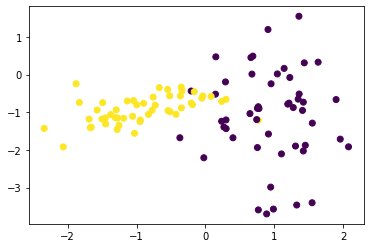

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.neural_network import MLPClassifier
from mlxtend.plotting import plot_decision_regions

X, y = make_classification(n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=23)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y)

scikit-learnの[MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)で学習。パラメータはデフォルトとします。

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


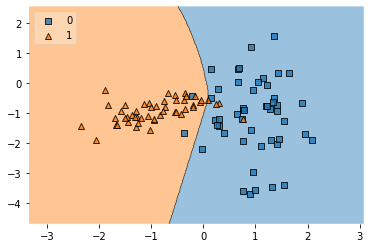

In [5]:
clf = MLPClassifier()
clf.fit(X,y)
plot_decision_regions(X=X, y=y, clf=clf, legend=2)

デフォルトの繰返し回数200回では誤差関数が収束していないという警告が出ています。インスタンス生成時の引数max_iterの値を少し大きく指定してみます。

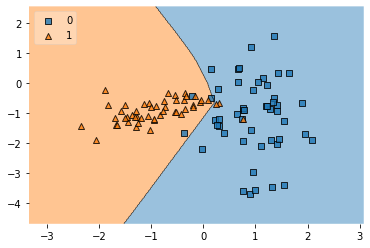

In [8]:
clf2 = MLPClassifier(max_iter=500)
clf2.fit(X,y)
plot_decision_regions(X=X, y=y, clf=clf2, legend=2)

識別面は変化していますが、性能はあまり変わらないように見えます。

## 課題

隠れ層のユニット数、活性化関数、学習率を変化させ、得られる識別面との関係を調べよ。繰り返し回数は未収束の警告が出ないように適当なものに設定せよ。

## 解答例

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


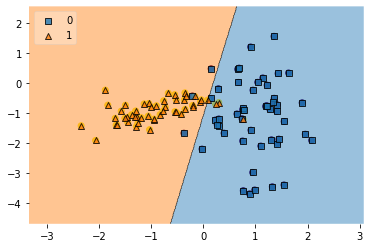

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.neural_network import MLPClassifier
from mlxtend.plotting import plot_decision_regions

X, y = make_classification(n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=23)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y)

clf3 = MLPClassifier(hidden_layer_sizes=(4,), activation='logistic', learning_rate_init=0.001, max_iter=1000)
clf3.fit(X,y)
plot_decision_regions(X=X, y=y, clf=clf3, legend=2)